In [1]:
import torch
import triton
import triton.language as tl
import os
from copy import deepcopy
import math
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
triton.__version__

'3.2.0'

# triton code

In [ ]:
# @triton.autotune([triton.Config({'BLOCK_SIZE_N': bsn, 'CHUNK_E':ce}, num_stages=ns, num_warps=nw)
#                  for bsn in [32, 64, 128]
#                  for ce in [32, 64, 128]
#                  for ns in [1,2,4]
#                  for nw in [4,8]
#                  ], key=['B', 'H', 'FP32'])
@triton.jit
def _lighting_attention_encode_kernel(QKV, KV, Y, SLOPE_RATE, NUM_PADDDINGS,
                                    qkv_sb, qkv_sn, qkv_sh, qkv_sd,
                                    kv_sb, kv_sh, kv_sd, kv_se,
                                    y_sb, y_sh, y_sn, y_sd,
                                    B, N, H, D:tl.constexpr, FP32:tl.constexpr,
                                    CHUNK_E:tl.constexpr,BLOCK_SIZE_N: tl.constexpr,
                                    ):
    off_b = tl.program_id(0).to(tl.int64)
    off_h = tl.program_id(1).to(tl.int64)
    off_e = (tl.program_id(2) * CHUNK_E).to(tl.int64)

    QKV = QKV + off_b * qkv_sb + off_h * qkv_sh
    KV = KV + off_b * kv_sb + off_h * kv_sh
    Y = Y + off_b * y_sb + off_h * y_sh
    SLOPE_RATE += off_h
    NUM_PADDDINGS += off_b
    dd = tl.arange(0, D)
    nn = tl.arange(0, BLOCK_SIZE_N)
    ee = tl.arange(0, CHUNK_E)

    num_paddings = tl.load(NUM_PADDDINGS)
    q_ptrs = QKV + (nn[:, None] + num_paddings) * qkv_sn + dd[None, :]
    k_ptrs = QKV + (nn[None, :] + num_paddings) * qkv_sn + dd[:, None] + D
    v_ptrs = QKV + (nn[:, None] + num_paddings) * qkv_sn + ee[None, :] + off_e + 2*D
    kv_ptrs = KV + dd[:, None] * kv_sd + ee[None, :] + off_e
    y_pts = Y + (nn[:, None] + num_paddings) * y_sn + ee[None, :] + off_e

    slope_rate = tl.load(SLOPE_RATE).to(tl.float32)

    array = (nn + 1)
    q_decay = tl.exp(-1. * slope_rate * array)[:, None]
    k_decay = tl.exp(-1. * slope_rate * (BLOCK_SIZE_N - array))[None, :]
    index = array[:, None] - array[None, :]
    s_index = slope_rate * index
    s_index = tl.where(index >= 0, -s_index, float('-inf'))
    diag_decay = tl.exp(s_index)

    if FP32:
        dtype = tl.float32
    else:
        dtype = tl.bfloat16
    kv = tl.zeros((D, CHUNK_E), dtype=tl.float32)
    
    for start_n in tl.range(num_paddings, N, BLOCK_SIZE_N):
        mask_nn = (nn + start_n) < N  
        m = tl.minimum(N-start_n, BLOCK_SIZE_N)
        if m < BLOCK_SIZE_N:
            tmp = -1. * slope_rate * (m - array)
            tmp = tl.where((m-array)<0, 0., tmp)
            k_decay = tl.exp(tmp)[None, :]
            
        q = tl.load(q_ptrs, mask=mask_nn[:, None], other=0.).to(dtype)
        k = tl.load(k_ptrs, mask=mask_nn[None, :], other=0.).to(dtype)
        v = tl.load(v_ptrs, mask=mask_nn[:, None], other=0.).to(dtype)

        qkv_none_diag = tl.dot((q * q_decay).to(dtype), kv.to(dtype))

        qk = tl.dot(q, k) * diag_decay
        qkv_diag = tl.dot(qk.to(dtype), v)
        y = qkv_diag + qkv_none_diag
        block_decay = tl.exp(-1. * slope_rate * m)
        kv = kv * block_decay + tl.dot((k * k_decay).to(dtype), v)
        # kv = tl.dot(tl.permute(k, (1,0)), k)
        
        tl.store(y_pts, y, mask=mask_nn[:, None])

        q_ptrs += BLOCK_SIZE_N * qkv_sn
        k_ptrs += BLOCK_SIZE_N * qkv_sn
        v_ptrs += BLOCK_SIZE_N * qkv_sn
        y_pts += BLOCK_SIZE_N * y_sn
        
    tl.store(kv_ptrs, kv)

# @triton.autotune([triton.Config({'CHUNK_E':ce}, num_stages=ns, num_warps=nw)
#                  for ce in [32, 64, 128]
#                  for ns in [1,2,3,4]
#                  for nw in [2,4,8]
#                  ], key=['B', 'N', 'H', 'FP32'])
@triton.jit
def _lighting_attention_decode_kernel(QKV, KV, Y, SLOPE_RATE,
                                    qkv_sb, qkv_sn, qkv_sh, qkv_sd,
                                    kv_sb, kv_sh, kv_sd, kv_se,
                                    y_sb, y_sh, y_sn, y_sd,
                                    B, N, H, D:tl.constexpr, FP32:tl.constexpr,
                                    CHUNK_E:tl.constexpr
                                    ):
    off_b = tl.program_id(0)
    off_h = tl.program_id(1)
    off_e = tl.program_id(2) * CHUNK_E 

    QKV += off_b * qkv_sb + off_h * qkv_sh
    KV += off_b * kv_sb + off_h * kv_sh
    Y += off_b * y_sb + off_h * y_sh
    SLOPE_RATE += off_h
    dd = tl.arange(0, D)
    ee = tl.arange(0, CHUNK_E)

    q_ptrs = QKV + dd
    v_prts = QKV + 2*D + ee + off_e
    kv_ptrs = KV + dd[:, None] * kv_sd + ee[None, :] + off_e
    y_ptrs = Y + ee + off_e

    slope_rate = tl.load(SLOPE_RATE).to(tl.float32)
    ratio = tl.exp(-1. * slope_rate)

    if FP32:
        dtype = tl.float32
    else:
        dtype = tl.bfloat16
    kv = tl.load(kv_ptrs).to(dtype)
    q = tl.load(q_ptrs).to(dtype)
    k = tl.load(q_ptrs+D).to(dtype)
    v = tl.load(v_prts).to(dtype)

    kv = ratio * kv + k[:, None] * v[None, :]
    y = tl.sum(q[:, None] * kv, axis=0)
    tl.store(kv_ptrs, kv)
    tl.store(y_ptrs, y)


def lighting_attention_encode(qkv, slope_rate, attention_mask=None, fp32=False):
    # b, n, h, d
    b, n, h, d3 = qkv.shape
    d = d3 // 3
    assert math.log2(d).is_integer(), 'd must be power of 2'
    slope_rate = slope_rate.squeeze()
    kv = torch.empty(b, h, d, d).to(torch.float32).to(qkv.device)
    y = torch.zeros(b, h, n, d, device=qkv.device, dtype=qkv.dtype)
    if attention_mask is not None:
        assert attention_mask[-1, :].min().values != 0, 'please use left_padding'
        num_paddings = n - attention_mask.sum(-1)
    else:
        num_paddings = torch.full((b,), 0, device=qkv.device, dtype=torch.int32)
    
    # A800的配置
    kwargs = {'BLOCK_SIZE_N':32, 'CHUNK_E': 64, 'num_warps': 4, 'num_stages':2 if fp32 else 1}
    # 第三个维度是我后来看lighting attention github上的代码学习到的！
    grids = lambda meta: (b, h, triton.cdiv(d, meta['CHUNK_E']))
    _lighting_attention_encode_kernel[grids](qkv, kv, y, slope_rate, num_paddings,
                                            *qkv.stride(),
                                            *kv.stride(),
                                            *y.stride(),
                                            b, n, h, d, fp32,
                                            **kwargs,
                                            )
    return y, kv

def lighting_attention_decode(qkv, slope_rate, kv, fp32=False):
    # b, n, h, d
    b, n, h, d3 = qkv.shape
    assert n == 1, 'decoing phase need n=1'
    d = d3 // 3
    slope_rate = slope_rate.squeeze()
    y = torch.empty(b, h, n, d, device=qkv.device, dtype=qkv.dtype)
    
    # A800的配置
    kwargs = {'CHUNK_E': 32, 'num_warps': 8, 'num_stages':4 if fp32 else 2}
    grids = lambda meta: (b, h, triton.cdiv(d, meta['CHUNK_E']))
    _lighting_attention_decode_kernel[grids](qkv, kv, y, slope_rate,
                                            *qkv.stride(),
                                            *kv.stride(),
                                            *y.stride(),
                                            b, n, h, d, fp32,
                                            **kwargs
                                            )
    return y, kv

def triton_lighting_attention(qkv, slope_rate, past_key_value=None, attention_mask=None, fp32=False):
    if past_key_value is None:
        y, kv = lighting_attention_encode(qkv, slope_rate, attention_mask, fp32)
    else:
        y, kv = lighting_attention_decode(qkv, slope_rate, past_key_value, fp32)
    return y, kv


# torch code

In [3]:
BLOCK = 256
def torch_lighting_attention(qkv, slope_rate, past_key_value=None, attention_mask=None):
    n = qkv.size(1)
    q, k, v = torch.split(qkv, [qkv.size(-1)//3] * 3, dim=3)
    # [b, h, l, d]
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    if past_key_value is None:
        offset = q.shape[-2]
    else:
        offset = 1

    # for align with metaseq
    ratio = torch.exp(-slope_rate)

    # only use for the first time
    if past_key_value is None:
        slope_rate = slope_rate.to(torch.float32)
        if attention_mask is not None:
            v = v.masked_fill((1 - attention_mask).unsqueeze(1).unsqueeze(-1).to(torch.bool), 0)
        # print(v[0, 0, :32])
        NUM_BLOCK = (n + BLOCK - 1) // BLOCK
        b, h, n, d = q.shape
        e = v.shape[-1]
        # other
        array = torch.arange(BLOCK).to(q) + 1
        q_decay = torch.exp(-slope_rate * array.reshape(-1, 1)) # h, bn, 1 
        k_decay = torch.exp(-slope_rate * (BLOCK - array.reshape(-1, 1)))
        index = array[:, None] - array[None, :]
        s_index = slope_rate * index[
            None,
            None,
        ]
        s_index = torch.where(index >= 0, -s_index, float("-inf"))
        diag_decay = torch.exp(s_index)

        kv = torch.zeros(b, h, d, e).to(torch.float32).to(q.device)
        output = torch.empty((b, h, n, e), dtype=q.dtype, device=q.device)
        for i in range(NUM_BLOCK):
            si = i * BLOCK
            ei = min(si + BLOCK, n)
            m = ei - si
            qi = q[:, :, si:ei].contiguous()
            ki = k[:, :, si:ei].contiguous()
            vi = v[:, :, si:ei].contiguous()
            qkv_none_diag = torch.matmul(qi * q_decay[:, :m], kv).to(torch.float32)

            # diag
            qk = torch.matmul(qi, ki.transpose(-1, -2)).to(torch.float32) * diag_decay[:, :, :m, :m]
            qkv_diag = torch.matmul(qk, vi.to(torch.float32))
            block_decay = torch.exp(-slope_rate * m)
            output[:, :, si:ei] = qkv_none_diag + qkv_diag
            kv = block_decay * kv + torch.matmul((ki * k_decay[:, -m:]).transpose(-1, -2).to(vi.dtype), vi)
    else:
        kv = past_key_value
        output = []
        for i in range(n):
            kv = ratio * kv + torch.einsum(
                "... n d, ... n e -> ... d e",
                k[:, :, i:i + 1],
                v[:, :, i:i + 1],
            )
            qkv = torch.einsum("... n e, ... e d -> ... n d", q[:, :, i:i + 1], kv.to(q.dtype))
            output.append(qkv)
        output = torch.concat(output, dim=-2)
    return output, kv


# 精度测试
- 这个attention真的离谱，精度差很多
- 原始代码中既有fp32也有bf16的矩阵乘

In [4]:
dtype = torch.bfloat16
device = 'cuda'
b, n, h, d = 8, 1020, 64, 128
qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
slope_rate = torch.rand(h, 1, 1, device=device, dtype=torch.float32) + 1e-3
gold_qkv = torch.rand_like(qkv, dtype=torch.float32).copy_(qkv)
attn_mask = torch.ones(b, n, device=device, dtype=torch.int32)
attn_mask[:, :30] = 0 

In [14]:
x1, x2 = torch_lighting_attention(qkv, slope_rate, attention_mask=attn_mask)
y1, y2 = triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask, fp32=False)
z1, z2 = torch_lighting_attention(gold_qkv, slope_rate, attention_mask=attn_mask)
print((x1-z1).abs().max(), (x1-z1).abs().mean())
print((y1-z1).abs().max(), (y1-z1).abs().mean())
print((x2-z2).abs().max(), (x2-z2).abs().mean())
print((y2-z2).abs().max(), (y2-z2).abs().mean())

tensor(2.0440, device='cuda:0') tensor(0.0366, device='cuda:0')
tensor(2.4799, device='cuda:0') tensor(0.0411, device='cuda:0')
tensor(0.1576, device='cuda:0') tensor(0.0031, device='cuda:0')
tensor(0.0861, device='cuda:0') tensor(0.0020, device='cuda:0')


In [8]:
y1.min()

tensor(nan, device='cuda:0', dtype=torch.bfloat16)

In [13]:
dtype = torch.bfloat16
device = 'cuda'
b, n, h, d = 8, 1, 64, 128
qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
kv =  torch.randn(b, h, d, d, dtype=torch.float32, device=device)
slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
gold_qkv = torch.rand_like(qkv, dtype=torch.float32).copy_(qkv)

In [14]:
x1, x2 = torch_lighting_attention(qkv, slope_rate, deepcopy(kv))
y1, y2 = lighting_attention_decode(qkv, slope_rate, deepcopy(kv), fp32=False)
z1, z2 = torch_lighting_attention(gold_qkv, slope_rate, deepcopy(kv))
print((x1-z1).abs().max(), (x1-z1).abs().mean())
print((y1-z1).abs().max(), (y1-z1).abs().mean())
print((x2-z2).abs().max(), (x2-z2).abs().mean())
print((y2-z2).abs().max(), (y2-z2).abs().mean())

tensor(0.3089, device='cuda:0') tensor(0.0257, device='cuda:0')
tensor(0.2961, device='cuda:0') tensor(0.0239, device='cuda:0')
tensor(0.0312, device='cuda:0') tensor(0.0009, device='cuda:0')
tensor(0.0358, device='cuda:0') tensor(0.0015, device='cuda:0')


# 性能测试
- encode 阶段bf16比fp32快一倍

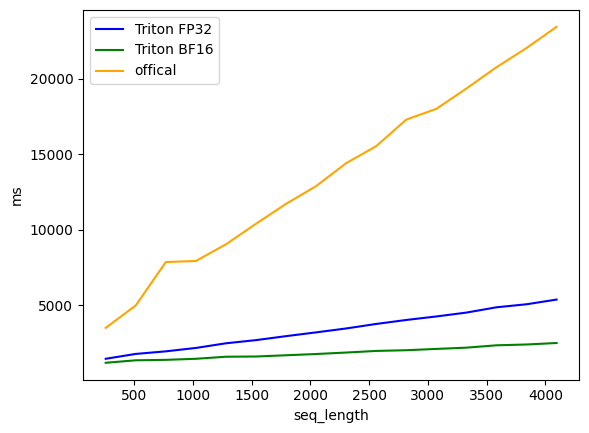

lighting attention encode phase:
    seq_length  Triton FP32  Triton BF16       offical
0        256.0  1445.158362  1179.984009   3493.651295
1        512.0  1767.088032  1344.447970   4981.471872
2        768.0  1938.016057  1374.240041   7858.732796
3       1024.0  2163.494492  1444.809616   7929.071999
4       1280.0  2472.287941  1581.276810   9033.264160
5       1536.0  2681.855917  1596.182406  10395.296097
6       1792.0  2945.689607  1678.188837  11716.121483
7       2048.0  3196.016002  1761.184013  12891.942310
8       2304.0  3455.392003  1858.752000  14413.065624
9       2560.0  3754.371214  1966.400027  15541.366100
10      2816.0  4018.294430  2012.560058  17300.535011
11      3072.0  4251.359940  2099.392080  18014.192200
12      3328.0  4507.699299  2183.059263  19362.316132
13      3584.0  4858.348751  2338.323116  20773.104477
14      3840.0  5058.803034  2392.054367  22046.899033
15      4096.0  5370.521545  2491.750336  23453.728485


In [4]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_length'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton FP32', 'Triton BF16', 'offical'],  # possible values for `line_arg``
        line_names=[
            "Triton FP32",
            'Triton BF16',
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="lighting attention encode phase",  # name for the plot. Used also as a file name for saving the plot.
        args={'h': 64, 'd': 128, 'b':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b,seq_length,h,d, provider):
    n = seq_length
    dtype = torch.bfloat16
    device = 'cuda'
    qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
    slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
    attn_mask = torch.ones(b, n, device=device, dtype=torch.int32)
    attn_mask[:, :n//10] = 0 
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    quantiles = [0.1, 0.3, 0.7]
    if provider == 'Triton FP32':
        ms, *_ = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask, fp32=True), rep=100, quantiles=quantiles)
    if provider == 'Triton BF16':
        ms, *_ = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask), rep=100, quantiles=quantiles)
    if provider == 'offical':
        ms, *_ = triton.testing.do_bench(lambda: torch_lighting_attention(qkv, slope_rate, attention_mask=attn_mask), rep=100, quantiles=quantiles)

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


- decode阶段fp32和bf16差不多，使用fp32即可

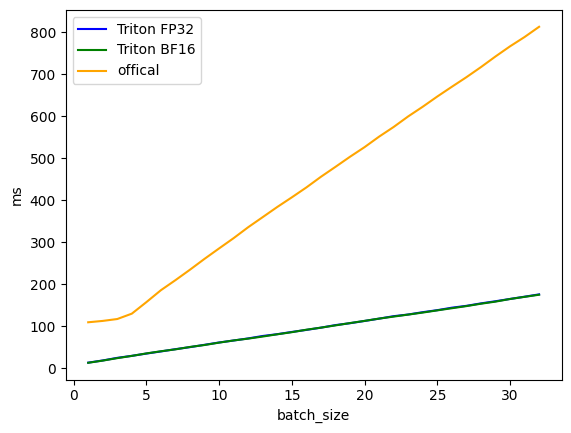

lighting attention decode phase:
    batch_size  Triton FP32  Triton BF16     offical
0          1.0    13.810877    13.489139  109.929165
1          2.0    18.975944    18.716724  113.172515
2          3.0    25.238146    24.574737  117.687179
3          4.0    30.018988    29.877224  130.478693
4          5.0    35.404936    35.768624  157.899168
5          6.0    40.484864    40.926066  186.333029
6          7.0    45.899834    45.482206  210.266890
7          8.0    50.771921    51.169060  235.179392
8          9.0    56.300555    55.819920  261.001221
9         10.0    61.812394    61.518433  285.797118
10        11.0    66.541705    66.659858  310.272857
11        12.0    71.486241    71.035924  336.301586
12        13.0    77.316052    75.987310  360.338310
13        14.0    81.605392    81.336036  384.481666
14        15.0    86.905932    86.345133  407.410012
15        16.0    91.745157    92.217067  430.969455
16        17.0    97.121829    97.139412  456.350412
17        18.

In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['batch_size'],  # argument names to use as an x-axis for the plot
        x_vals=[i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton FP32', 'Triton BF16', 'offical'],  # possible values for `line_arg``
        line_names=[
            "Triton FP32",
            'Triton BF16',
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="lighting attention decode phase",  # name for the plot. Used also as a file name for saving the plot.
        args={'h': 64, 'd': 128, 'n':1}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(batch_size,n,h,d, provider):
    b = batch_size
    dtype = torch.bfloat16
    device = 'cuda'
    qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
    kv =  torch.randn(b, h, d, d, dtype=torch.float32, device=device)
    slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    quantiles = [0.5, 0.3, 0.7]
    if provider == 'Triton FP32':
        ms = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, kv, fp32=True), rep=100)
    if provider == 'Triton BF16':
        ms = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, kv), rep=100)
    if provider == 'offical':
        ms = triton.testing.do_bench(lambda: torch_lighting_attention(qkv, slope_rate, kv), rep=100)

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
